**1. INSTALACION DE DEPENDENCIAS**

In [24]:
#@title Instalación de dependencias e importaciones globales
!pip -q install medmnist==3.0.1 torch torchvision torchaudio matplotlib scikit-learn pandas

# Librerías base
import os, random, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

# Visualización y análisis
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from datetime import datetime

# Dataset MedMNIST
from medmnist import BreastMNIST

# Configuración reproducible
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cpu


**2. Carga del dataset (size=28) y exploración**

In [2]:
#@title Carga simple de BreastMNIST (size=28) y DataLoaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])  # [-1,1]
])

train_ds = BreastMNIST(split="train", download=True, size=28, transform=transform)
val_ds   = BreastMNIST(split="val",   download=True, size=28, transform=transform)
test_ds  = BreastMNIST(split="test",  download=True, size=28, transform=transform)

BATCH_SIZE_BASE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE_BASE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE_BASE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE_BASE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


100%|██████████| 560k/560k [00:00<00:00, 1.01MB/s]


(546, 78, 156)

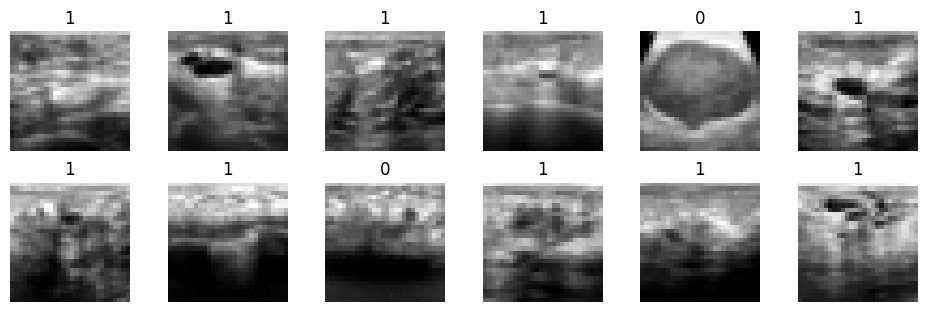

In [3]:
#@title Visualización de muestras
def show_samples(dataset, rows=2, cols=6):
    plt.figure(figsize=(cols*1.6, rows*1.6))
    for i in range(rows*cols):
        img, label = dataset[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        # el label puede venir como tensor [[0],[1]] o [0]/[1]
        y = int(label.squeeze().item())
        plt.title(y)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_ds)


**3. Definición del MLP y utilidades de entrenamiento**

In [18]:
#@title Modelo MLP (para 28x28) y funciones de entrenamiento/evaluación
INPUT_DIM = 28 * 28
N_CLASSES = 1           # BreastMNIST es binario -> salida 1 (logit)
TASK = 'binary-class'   # para claridad en el flujo

class MLP(nn.Module):
    def __init__(self, hidden_layers=[256,128], activation='relu', p_drop=0.2):
        super().__init__()
        act = nn.ReLU if activation.lower()=='relu' else nn.LeakyReLU

        layers, prev = [], INPUT_DIM
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act(), nn.Dropout(p_drop)]
            prev = h
        layers += [nn.Linear(prev, N_CLASSES)]  # salida 1 logit para binario
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # (B, 784)
        return self.net(x)

def get_loss(task=TASK):
    # Para binario usamos BCEWithLogitsLoss
    return nn.BCEWithLogitsLoss()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    criterion = get_loss()
    total, correct, losses = 0, 0, []
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        # BreastMNIST entrega etiquetas en {0,1} con shape (B,1)
        y = y.float().to(device).squeeze()  # (B,)
        logits = model(x).squeeze()         # (B,)
        loss = criterion(logits, y)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += y.numel()
        losses.append(loss.item())
        y_true.extend(y.long().cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
    acc = correct / total
    return np.mean(losses), acc, np.array(y_true), np.array(y_pred)

def train_one_config(hidden_layers, activation, optimizer_name, lr, batch_size, epochs=10, p_drop=0.2, verbose=False):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = MLP(hidden_layers=hidden_layers, activation=activation, p_drop=p_drop).to(device)
    criterion = get_loss()

    if optimizer_name.lower()=='sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc, best_state = -1, None

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.float().to(device).squeeze()
            optimizer.zero_grad()
            logits = model(x).squeeze()
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        val_loss, val_acc, _, _ = evaluate(model, val_loader)
        if verbose:
            print(f"[{ep:02d}/{epochs}] train_loss={np.mean(losses):.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}

    # cargar el mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_val_acc


**4. Modelo base y evaluación inicial**

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[01/10] train_loss=0.6447 | val_loss=0.5676 | val_acc=0.7308
[02/10] train_loss=0.5743 | val_loss=0.5485 | val_acc=0.7308
[03/10] train_loss=0.5248 | val_loss=0.5050 | val_acc=0.7308
[04/10] train_loss=0.5363 | val_loss=0.4902 | val_acc=0.7949
[05/10] train_loss=0.5072 | val_loss=0.4809 | val_acc=0.8333
[06/10] train_loss=0.4974 | val_loss=0.4653 | val_acc=0.8205
[07/10] train_loss=0.4920 | val_loss=0.4822 | val_acc=0.7821
[08/10] train_loss=0.4833 | val_loss=0.4622 | val_acc=0.8205
[09/10] train_loss=0.4475 | val_loss=0.4527 | val_acc=0.8590
[10/10] train_loss=0.4344 | val_loss=0.4471 | val_acc=0.8590
Baseline -> Val acc:  0.8590
Baseline -> Test acc: 0.7949


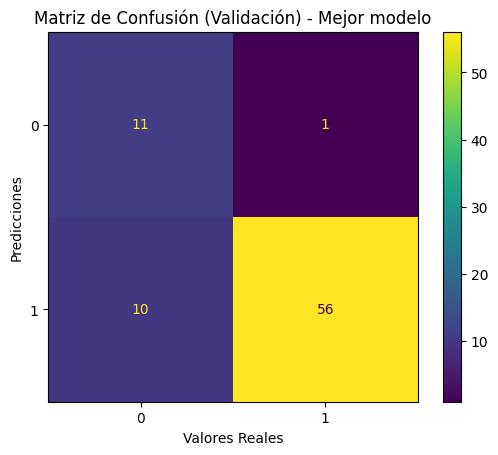

Reporte de clasificación (Validación) - Baseline
              precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667        21
           1     0.8485    0.9825    0.9106        57

    accuracy                         0.8590        78
   macro avg     0.8826    0.7531    0.7886        78
weighted avg     0.8668    0.8590    0.8449        78



In [19]:
#@title Entrenamiento del modelo base (baseline)
BASE_CFG = {
    "hidden_layers": [256, 128],
    "activation": "relu",
    "optimizer_name": "adam",
    "lr": 1e-3,
    "batch_size": 128,
    "epochs": 10,
    "p_drop": 0.2
}

set_seed(SEED)
base_model, base_val_acc = train_one_config(**BASE_CFG, verbose=True)
val_loss_b, val_acc_b, y_true_val_b, y_pred_val_b = evaluate(base_model, val_loader)
test_loss_b, test_acc_b, y_true_test_b, y_pred_test_b = evaluate(base_model, test_loader)

print(f"Baseline -> Val acc:  {val_acc_b:.4f}")
print(f"Baseline -> Test acc: {test_acc_b:.4f}")

# Matriz de confusión con eje X = reales y Y = predicciones
cm_val = confusion_matrix(y_true_val_b, y_pred_val_b)

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val.T)  # Transpuesta
disp_val.plot()
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Matriz de Confusión (Validación) - Mejor modelo")
plt.show()

print("Reporte de clasificación (Validación) - Baseline")
print(classification_report(y_true_val_b, y_pred_val_b, digits=4))

**5. Búsqueda de hiperparámetros (grid compacto)**

In [21]:
#@title Grid de hiperparámetros
SEARCH_EPOCHS = 25  # Exploración rápida

grid = [
    # (hidden_layers,      activation, optimizer, lr,      batch)
    ([256],               "relu",     "sgd",      0.01,    128),
    ([256],               "relu",     "adam",     0.001,   128),
    ([256],               "leakyrelu","adam",     0.001,    64),

    ([256,128],           "relu",     "sgd",      0.01,    128),
    ([256,128],           "relu",     "adam",     0.001,   128),
    ([256,128],           "leakyrelu","adam",     0.0001,  256),

    ([512,256,128],       "relu",     "sgd",      0.01,    128),
    ([512,256,128],       "relu",     "adam",     0.001,   128),
    ([512,256,128],       "leakyrelu","adam",     0.0001,  256),
]

results = []
best = (-1, None, None)  # (val_acc, cfg, state_dict)

for (hls, act, opt, lr, bs) in grid:
    set_seed(SEED)
    model, val_acc = train_one_config(
    hidden_layers=hls, activation=act, optimizer_name=opt,
    lr=lr, batch_size=bs, epochs=SEARCH_EPOCHS, p_drop=0, verbose=False
)

    results.append({
        "hidden_layers": str(hls),
        "activation": act,
        "optimizer": opt,
        "lr": lr,
        "batch_size": bs,
        "p_drop": 0, # p_drop is not in the grid, so we hardcode it to 0
        "val_acc": float(val_acc)
    })
    # almacenar mejor
    if val_acc > best[0]:
        best = (val_acc, (hls, act, opt, lr, bs, 0), {k: v.cpu() for k,v in model.state_dict().items()}) # p_drop is not in the grid, so we hardcode it to 0

df_results = pd.DataFrame(results).sort_values("val_acc", ascending=False).reset_index(drop=True)
df_results

,hidden_layers,activation,optimizer,lr,batch_size,p_drop,val_acc
0,[256],relu,adam,0.0010,128,0,0.897436
1,[256],relu,sgd,0.0100,128,0,0.884615
2,[256],leakyrelu,adam,0.0010,64,0,0.884615
3,"[256, 128]",relu,sgd,0.0100,128,0,0.871795
4,"[256, 128]",relu,adam,0.0010,128,0,0.858974
5,"[512, 256, 128]",relu,adam,0.0010,128,0,0.858974
6,"[512, 256, 128]",leakyrelu,adam,0.0001,256,0,0.846154
7,"[256, 128]",leakyrelu,adam,0.0001,256,0,0.769231
8,"[512, 256, 128]",relu,sgd,0.0100,128,0,0.730769


In [22]:
#@title Top-5 configuraciones por accuracy de validación
df_results.head(5)


,hidden_layers,activation,optimizer,lr,batch_size,p_drop,val_acc
0,[256],relu,adam,0.001,128,0,0.897436
1,[256],relu,sgd,0.010,128,0,0.884615
2,[256],leakyrelu,adam,0.001,64,0,0.884615
3,"[256, 128]",relu,sgd,0.010,128,0,0.871795
4,"[256, 128]",relu,adam,0.001,128,0,0.858974


**6. Reentrenamiento de la mejor configuración y evaluación final**

Mejor configuración encontrada: [256] relu adam 0.001 128 0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[01/30] train_loss=0.5917 | val_loss=0.5240 | val_acc=0.7821
[02/30] train_loss=0.5070 | val_loss=0.4939 | val_acc=0.7692
[03/30] train_loss=0.5172 | val_loss=0.4655 | val_acc=0.7949
[04/30] train_loss=0.5027 | val_loss=0.4323 | val_acc=0.8462
[05/30] train_loss=0.4765 | val_loss=0.4217 | val_acc=0.8590
[06/30] train_loss=0.4689 | val_loss=0.4183 | val_acc=0.8718
[07/30] train_loss=0.4669 | val_loss=0.4100 | val_acc=0.8590
[08/30] train_loss=0.4472 | val_loss=0.4092 | val_acc=0.8846
[09/30] train_loss=0.4374 | val_loss=0.3975 | val_acc=0.8846
[10/30] train_loss=0.4098 | val_loss=0.3969 | val_acc=0.8846
[11/30] train_loss=0.4096 | val_loss=0.3905 | val_acc=0.8846
[12/30] train_loss=0.3891 | val_loss=0.3854 | val_acc=0.8974
[13/30] train_loss=0.4000 | val_loss=0.3839 | val_acc=0.8718
[14/30] train_loss=0.3831 | val_loss=0.3839 | val_acc=0.8846
[15/30] train_loss=0.3824 | val_loss=0.3786 | val_acc=0.8846
[16/30] train_loss=0.3701 | val_loss=0.3742 | val_acc=0.8846
[17/30] train_loss=0.353

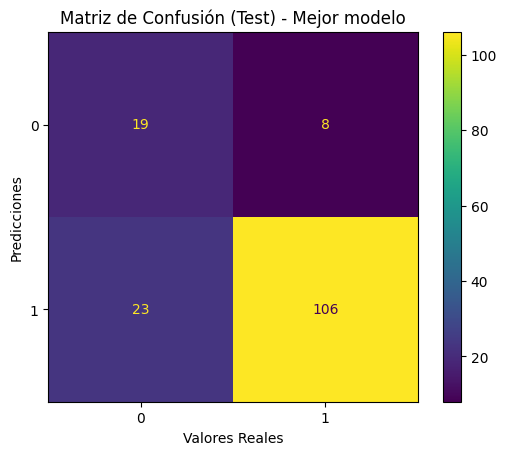

Reporte de clasificación (Test) - Mejor modelo
              precision    recall  f1-score   support

           0     0.7037    0.4524    0.5507        42
           1     0.8217    0.9298    0.8724       114

    accuracy                         0.8013       156
   macro avg     0.7627    0.6911    0.7116       156
weighted avg     0.7899    0.8013    0.7858       156



In [23]:
#@title Reentrenamiento extendido y evaluación final
(hls, act, opt, lr, bs, p_drop) = best[1]
print("Mejor configuración encontrada:", hls, act, opt, lr, bs, p_drop)

EXTENDED_EPOCHS = 30  # más largo para el mejor
set_seed(SEED)
best_model, _ = train_one_config(
    hidden_layers=hls, activation=act, optimizer_name=opt,
    lr=lr, batch_size=bs, epochs=EXTENDED_EPOCHS, p_drop=p_drop, verbose=True
)

val_loss_f, val_acc_f, y_true_val_f, y_pred_val_f = evaluate(best_model, val_loader)
test_loss_f, test_acc_f, y_true_test_f, y_pred_test_f = evaluate(best_model, test_loader)

print(f"[FINAL] Val acc:  {val_acc_f:.4f}")
print(f"[FINAL] Test acc: {test_acc_f:.4f}")

# Guardar pesos
os.makedirs("checkpoints", exist_ok=True)
model_path = f"checkpoints/mlp_breastmnist_best_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
torch.save(best_model.state_dict(), model_path)
print("Pesos guardados en:", model_path)

# Visualización en TEST
cm_test = confusion_matrix(y_true_test_f, y_pred_test_f)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test.T)  # Transpuesta
disp_test.plot()
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Matriz de Confusión (Test) - Mejor modelo")
plt.show()


print("Reporte de clasificación (Test) - Mejor modelo")
print(classification_report(y_true_test_f, y_pred_test_f, digits=4))
